In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import fsolve

In [2]:
time = np.linspace(0,8,500) #from the paper

## Parameters to find from the paper

$\hat{\mu}, K_s, K_i, P_{max}$ and $n$ 

In [3]:
#initial conditions:

X0 = 25.0 #g/L
S0 = 111.5 #g/L
P0 = 0 #g/L

initialvals = [S0, X0, P0]

#Parameters in the paper

mupaper = 0.5
Kspaper = 6.1e-3
Kipaper = 139.7
Pmaxpaper = 94.2 
npaper = 4.12

params1 = mupaper, Kspaper, Kipaper, Pmaxpaper, npaper

In [4]:
#Other values calculated in the paper through regression

alpha = 4.87 #g/g
Yps = 0.4 #g/g
Yxp = 1/alpha

In [5]:
def ode(z, t):
    S = z[0]
    X = z[1]
    P = z[2]
    
    mu, Ks, Ki, Pmax, n = params1
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    
    return ([dSdt, dXdt, dPdt])

answer = odeint(ode, initialvals, time)


S = answer[:,0]
X = answer[:,1]
P = answer[:,2]

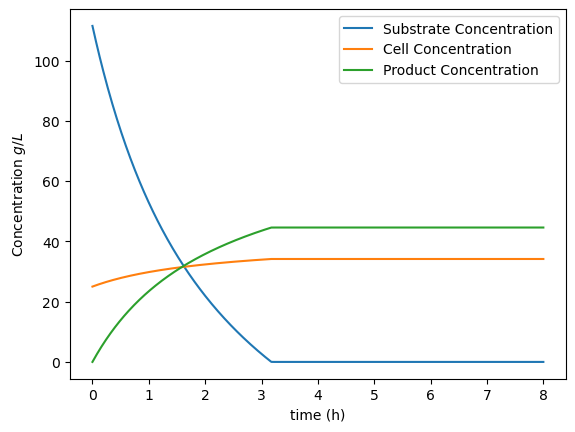

In [6]:
plt.plot(time, answer[:,0], label = 'Substrate Concentration')
plt.plot(time, answer[:,1], label = 'Cell Concentration')
plt.plot(time, answer[:,2], label = 'Product Concentration')
plt.xlabel('time (h)')
plt.ylabel('Concentration $g/L$')
plt.legend()


# To us, the important part is the product concentration as the time goes on.

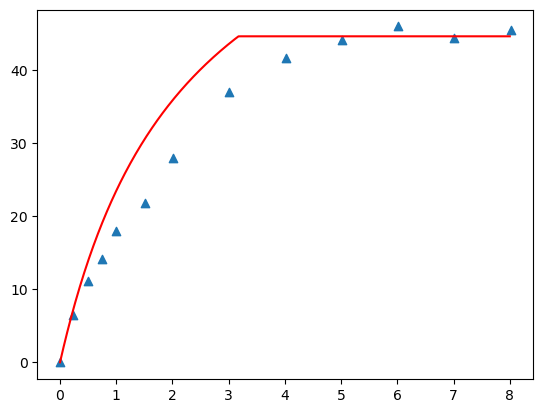

In [7]:
product = answer[:,2]
prodpaper = pd.read_csv('Product.csv', header=0)

papertime = prodpaper['Time']
paperconcProd = prodpaper['Concentration']

plt.scatter(papertime,paperconcProd, marker = '^')
plt.plot(time,product, color = 'r')

In [59]:
cellpaper = pd.read_csv('Cell.csv', header=0)


# Optimizing the function by considering own initial position, get the parameters and calculate function.

[[111.5         25.           0.        ]
 [ 39.33259478  30.92750762  28.86696209]
 [ 31.59560793  31.56298908  31.96175683]
 [ 27.51791756  31.89791232  33.59283298]
 [ 24.813654    32.12002842  34.6745384 ]
 [ 22.81938117  32.28382906  35.47224753]
 [ 21.25470892  32.41234424  36.09811643]
 [ 19.97602427  32.51736967  36.60959029]
 [ 18.90041396  32.60571549  37.03983442]
 [ 17.97589141  32.68165163  37.40964344]
 [ 17.16782606  32.7480225   37.73286958]
 [ 16.45205174  32.806813    38.0191793 ]
 [ 15.81107257  32.85946016  38.27557097]]


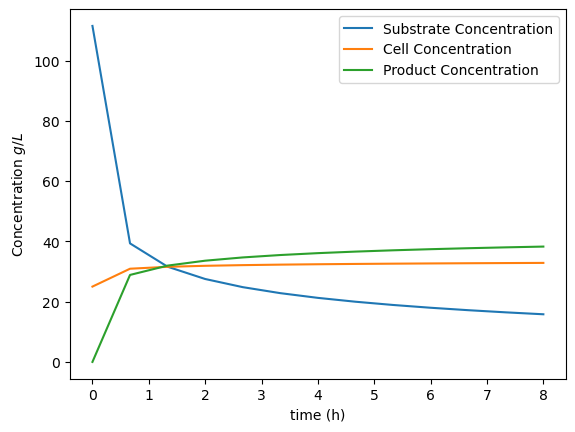

In [8]:
X0 = 25.0  # g/L
S0 = 111.5  # g/L
P0 = 0.0    # g/L
myinitialvals = [S0, X0, P0]

alpha = 4.87 #g/g
Yps = 0.4 #g/g
Yxp = 1/alpha

def myode(z, t, myparams):
    S = z[0]
    X = z[1]
    P = z[2]
    
    mu, Ks, Ki, Pmax, n = myparams
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    return ([dSdt, dXdt, dPdt])

time = np.linspace(0,8,13)

myparamsguess = (10, 5, 200, 56, 7)

mysol = odeint(myode, myinitialvals, time, args=(myparamsguess,))
print(mysol)

plt.plot(time, mysol[:,0], label = 'Substrate Concentration')
plt.plot(time, mysol[:,1], label = 'Cell Concentration')
plt.plot(time, mysol[:,2], label = 'Product Concentration')
plt.xlabel('time (h)')
plt.ylabel('Concentration $g/L$')
plt.legend()

# Getting the error

2070.928654925676


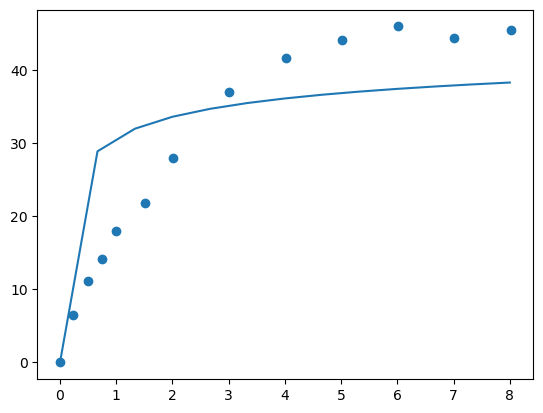

In [9]:
papertimeProd = prodpaper['Time']
paperconcProd = prodpaper['Concentration']

Prodtime = papertimeProd.tolist()
Prodconc = paperconcProd.tolist()

# print(Prodtime, Prodconc)


errorProd = np.sum((mysol[:,2] - Prodconc)**2)

print(errorProd)

# def minfunc(params, *args):

plt.plot(time, mysol[:,2], label = 'Calculated Product')
plt.scatter(Prodtime, Prodconc, label = 'Experimental Product')

## Using the minimize function

In [10]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

def cost_function(params, *args):
    myparams = params
    Prodconc, time, myinitialvals = args
    
    model_output = odeint(myode, myinitialvals, time, args=(myparams,))
    
    error_P = np.sum((model_output[:, 2] - Prodconc) ** 2)
    
    return error_P

# bounds = Bounds([0.3, 6.7e-3, 120, 93, 3], [0.5, 1, 142, 120, 5])
# bounds = Bounds([0.4934834, 0.0061235, 128.34832, 98.5642, 2.5645], [1, 0.89343, 140.23565, 102.543423, 4.89234123])

# 0.5,  1,  129.85, 101.65,  5
# Perform optimization using the Nelder-Mead algorithm
result = minimize(cost_function, myparamsguess, args=(Prodconc, time, myinitialvals), method='Nelder-Mead')#, bounds=bounds)


#method='Nelder-Mead'
#method='L-BFGS-B'
optimized_params = result.x

print("Optimized Parameters:", optimized_params)
print(result)


Optimized Parameters: [  0.6551595   26.87506472  10.13670957 429.21505531  10.13237992]
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 20.060797843345178
             x: [ 6.552e-01  2.688e+01  1.014e+01  4.292e+02  1.013e+01]
           nit: 615
          nfev: 1000
 final_simplex: (array([[ 6.552e-01,  2.688e+01, ...,  4.292e+02,
                         1.013e+01],
                       [ 6.495e-01,  2.682e+01, ...,  4.292e+02,
                         1.021e+01],
                       ...,
                       [ 6.236e-01,  2.686e+01, ...,  4.235e+02,
                         9.764e+00],
                       [ 6.223e-01,  2.687e+01, ...,  4.230e+02,
                         9.712e+00]]), array([ 2.006e+01,  2.008e+01,  2.016e+01,  2.017e+01,
                        2.018e+01,  2.019e+01]))


[[111.5         25.           0.        ]
 [ 39.33259478  30.92750762  28.86696209]
 [ 31.59560793  31.56298908  31.96175683]
 [ 27.51791756  31.89791232  33.59283298]
 [ 24.813654    32.12002842  34.6745384 ]
 [ 22.81938117  32.28382906  35.47224753]
 [ 21.25470892  32.41234424  36.09811643]
 [ 19.97602427  32.51736967  36.60959029]
 [ 18.90041396  32.60571549  37.03983442]
 [ 17.97589141  32.68165163  37.40964344]
 [ 17.16782606  32.7480225   37.73286958]
 [ 16.45205174  32.806813    38.0191793 ]
 [ 15.81107257  32.85946016  38.27557097]]


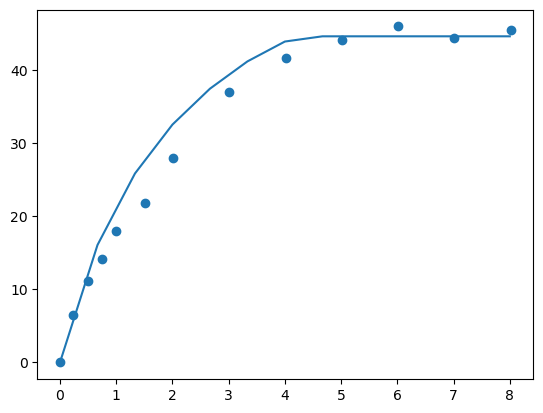

In [11]:
X0 = 25.0  # g/L
S0 = 111.5  # g/L
P0 = 0.0    # g/L
myinitialvals = [S0, X0, P0]

alpha = 4.87 #g/g
Yps = 0.4 #g/g
Yxp = 1/alpha

def myode(z, t, myparams):
    S = z[0]
    X = z[1]
    P = z[2]
    
    mu, Ks, Ki, Pmax, n = myparams
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    return ([dSdt, dXdt, dPdt])

time = np.linspace(0,8,13)

# myparamsguess = (4.664e-01,  3.238e-01,  1.557e+01,  1.897e+02,  5.387e+00)
# myparamsguess = (2.415e-01,  6.268e-03,  3.178e+01,  9.762e+01,  1.870e+00)
# myparamsguess = (0.3,  2.38304329e-02,  120,  93,  5)
# myparamsguess = (0.3,  7.5000e-03, 1.2900e+02, 1.0165e+02, 5.0000e+00)
# myparamsguess = (0.5,  1,  129.85, 101.65,  5)
myparamsguess = (0.4934834,    0.89343,    128.34832,     98.5642,       4.89234123)

mysol1 = odeint(myode, myinitialvals, time, args=(myparamsguess,))
print(mysol)

plt.plot(time, mysol1[:,2])
plt.scatter(Prodtime, Prodconc, label = 'Experimental Product')

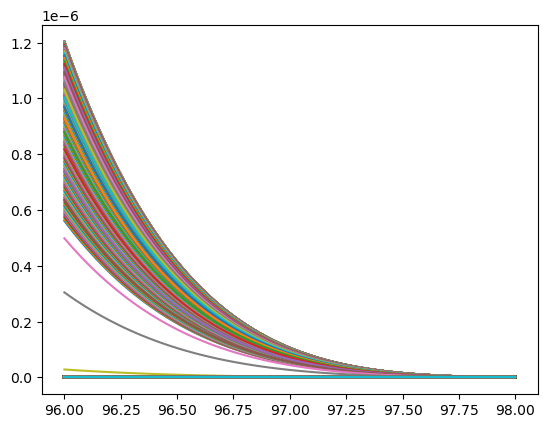

In [29]:
# g = (1-P/Pmax)**(n)
# muB = mu*S/(Ks + S + S**2/Ki)*g
# pi = muB * alpha
# sigma = pi/Yps
    
# dSdt = -sigma*X
# dXdt = muB*X
# dPdt = pi*X

goodmu = 0.4934
goodKs = 0.893
goodKi = 128.348
goodPmax = 98.56
goodn = 4.892

goodparams = goodmu, goodKs, goodKi, goodPmax, goodn

def dPdt(P):
    g = (1-P/goodPmax)**(goodn)
    muB = goodmu*S/(goodKs + S + S**2/goodKi)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    return dPdt

Pvalues = np.linspace(96,98,100)
dPdt_values = []
for m in Pvalues:
    dPdt_values.append(dPdt(m))
    
plt.plot(Pvalues, dPdt_values)
# plt.xlim(-.1,.1)
plt.show()

# Using fsolve to find steady states

basically starting over too

In [26]:
X0 = 25.0 #g/L
S0 = 111.5 #g/L
P0 = 0 #g/L

initialvals = [S0, X0, P0]

alpha = 4.87 #g/g
Yps = 0.4 #g/g
Yxp = 1/alpha

goodmu = 0.4934
goodKs = 0.893
goodKi = 128.348
goodPmax = 98.56
goodn = 4.892

# 0.6551595   26.87506472  10.13670957 429.21505531  10.13237992
goodparams = goodmu, goodKs, goodKi, goodPmax, goodn

def myode(z, t, myparams):
    S = z[0]
    X = z[1]
    P = z[2]
    
    mu, Ks, Ki, Pmax, n = myparams
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    return ([dSdt, dXdt, dPdt])

time = np.linspace(0,8,13)

def SSP(P, params):
    
    S = initialvals[0]
    X = initialvals[1]
    
    mu, Ks, Ki, Pmax, n = params
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    eq = pi*X - sigma*X
    return eq

PSS = fsolve(SSP, P0, args=(goodparams,))
print(PSS)

[98.56]


# Flow on a Line Analysis and Fsolve to find steady state show that there there is a steady state around 98.

**Now testing by changing value of Ki to see how the equation changes, essentially doing a simple bifurcation**

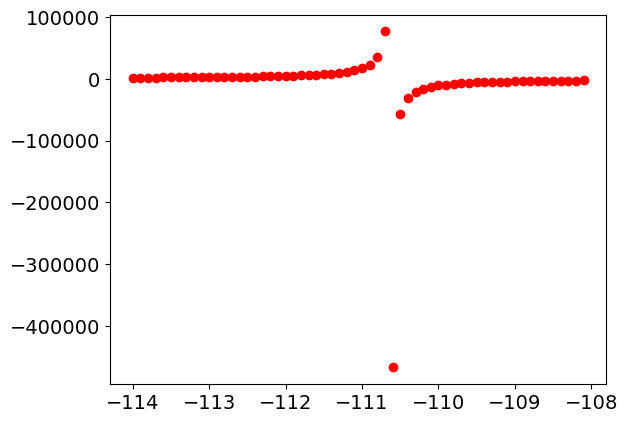

In [81]:
Kitest = np.arange(-114,-108,0.1)



def BiAnalysis(Ki, params):

    mu, Ks, Pmax, n = params
    
#     mu = 0.4934
#     Ks = 0.893
# #     Ki = 128.348
#     Pmax = 98.56
#     n = 4.892
    alpha = 4.87 #g/g
    Yps = 0.4
    
    S = initialvals[0]
    X = initialvals[1]
    P = initialvals[2]
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    return dPdt

goodparams = [goodmu, goodKs, goodPmax, goodn]

dPdt_values = [BiAnalysis(Ki, goodparams) for Ki in Kitest]


# plt.scatter(Kitest, dPdt_values)
plt.plot(Kitest, dPdt_values, 'ro')
# plt.ylim(-500,500)
plt.show()

# Kitest = np.arange(125, 136, 1)  # Adjust the range to include 135

# # Function to calculate dP/dt for a given Ki
# def BiAnalysis(Ki, params):
#     mu, Ks, Kitest, Pmax, n = params
    
#     S = initialvals[0]
#     X = initialvals[1]

#     g = (1 - P / Pmax) ** n
#     muB = mu * S / (Ks + S + S ** 2 / Ki) * g
#     pi = muB * alpha
#     sigma = pi / Yps
    
#     dSdt = -sigma * X
#     dXdt = muB * X
#     dPdt = pi * X
    
#     # Define the system of ODEs
#     def myode(z, t):
#         S, X, P = z
#         muB = mu * S / (Ks + S + S ** 2 / Ki) * (1 - P / Pmax) ** n
#         pi = muB * alpha
#         sigma = pi / Yps
#         dSdt = -sigma * X
#         dXdt = muB * X
#         dPdt = pi * X
#         return [dSdt, dXdt, dPdt]

#     # Integrate the system of ODEs
#     sol = odeint(myode, initialvals, time)

#     # Return the steady-state value of dP/dt
#     return sol[-1, 2] * pi  # dP/dt = pi * X

# # Calculate dP/dt for each Ki
# dPdt_values = [BiAnalysis(Ki, goodparams) for Ki in Kitest]

# # Plot the bifurcation diagram
# plt.plot(Kitest, dPdt_values, 'o-')  # Use 'o-' to connect the points with lines
# plt.xlabel('Ki')
# plt.ylabel('dP/dt')
# plt.title('Bifurcation Analysis')
# plt.show()

## But what if I want to test Ks by only changing Ks

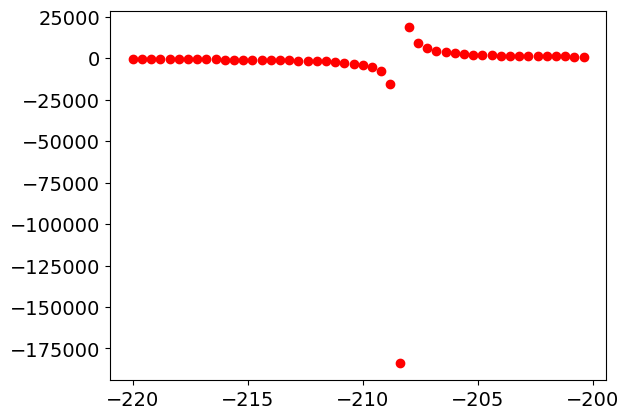

In [86]:
Kstest = np.arange(-220,-200,0.4)



def BiAnalysis(Ks, params):

    mu, Ki, Pmax, n = params
    
#     mu = 0.4934
#     Ks = 0.893
# #     Ki = 128.348
#     Pmax = 98.56
#     n = 4.892
    alpha = 4.87 #g/g
    Yps = 0.4
    
    S = initialvals[0]
    X = initialvals[1]
    P = initialvals[2]
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    return dPdt

goodparams = [goodmu, goodKi, goodPmax, goodn]

dPdt_values = [BiAnalysis(Ks, goodparams) for Ks in Kstest]


# plt.scatter(Kitest, dPdt_values)
plt.plot(Kstest, dPdt_values, 'ro')
plt.show()

In [ ]:
Ksbi = np.linspace(1,10,500)

/var/folders/gw/gflpw3b111799vjqwnjtfw7w0000gn/T/ipykernel_47062/3742034743.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/gw/gflpw3b111799vjqwnjtfw7w0000gn/T/ipykernel_47062/3742034743.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Ki')


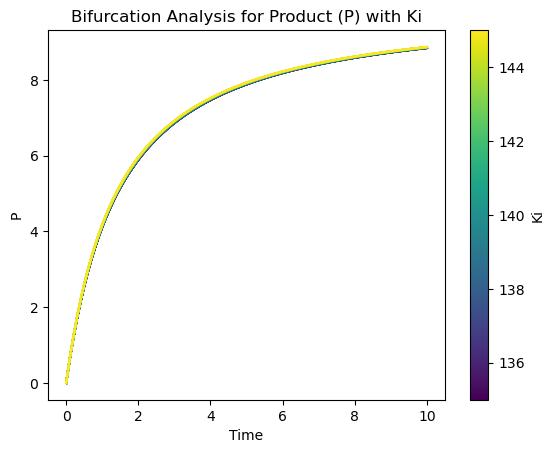

In [33]:
from matplotlib import cm

def ode(z, t, params):
    S, X, P = z
    mu, Ks, Ki, Pmax, n, alpha, Yps = params
    
    g = (1 - P / Pmax)**(n)
    muB = mu * S / (Ks + S + S**2 / Ki) * g
    pi = muB * alpha
    sigma = pi / Yps
    
    dSdt = -sigma * X
    dXdt = muB * X
    dPdt = pi * X
    
    return [dSdt, dXdt, dPdt]


Ks = 6.10e-3
mu = 0.1
Pmax = 10.0
n = 2.0
alpha = 4.87
Yps = 0.4

S0 = 111.5  # g/L
X0 = 25.0   # g/L
P0 = 0.0    # g/L
initialvals = [S0, X0, P0]


time = np.linspace(0, 10, 200)


Ki_values = np.linspace(135, 145, 50)

cmap = cm.get_cmap('viridis')

for Ki in Ki_values:
    params = [mu, Ks, Ki, Pmax, n, alpha, Yps]
    ans = odeint(ode, initialvals, time, args=(params,))
    
    plt.plot(time, ans[:, 2], color=cmap((Ki - 135) / 10), label=f'Ki = {Ki:.2f}')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=135, vmax=145))

plt.colorbar(sm, label='Ki')

plt.xlabel('Time')
plt.ylabel('P')
plt.title('Bifurcation Analysis for Product (P) with Ki')
# plt.ylim(0,1)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def ode_functions(z, t, params):
    S, X, P = z
    mu, Ks, Ki, Pmax, n, alpha, Yps = params

    g = (1 - P / Pmax)**(n)
    muB = mu * S / (Ks + S + S**2 / Ki) * g
    pi = muB * alpha
    sigma = pi / Yps

    dSdt = -sigma * X
    dXdt = muB * X
    dPdt = pi * X
    
    return [dSdt, dXdt, dPdt]

initialvals = [S0, X0, P0]

out_P = []
out_t = []
out_Ks = []

for Ks in np.linspace(0.1, 2.0, 100):
    params = [mu, Ks, Ki, Pmax, n, alpha, Yps]

    # Solve the ODE for each value of Ks
    z = odeint(ode_functions, initialvals, time, args=(params,))
    P = z[:, 2]

    # Collect data for plotting
    out_P = np.append(out_P, P)
    out_t = np.append(out_t, time)
    out_Ks = np.append(out_Ks, [Ks] * len(time))

    # Update initial conditions for the next loop
    initialvals = [z[-1, 0], z[-1, 1], z[-1, 2]]

# Plot bifurcation analysis for dPdt with respect to Ks
plt.rcParams.update({'font.size': 14})
plt.xlabel("time")
plt.ylabel("P")

from matplotlib import colors

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.linspace(0.1, 2.0, 100), cmap.N)

plt.scatter(out_t, out_P, c=out_Ks, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.linspace(0.1, 2.0, 9))
cbar.set_label('Ks values')

plt.title('Bifurcation Analysis for dP/dt with varying Ks')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import colors

def ode_functions(z, t, params):
    S, X, P = z
    mu, Ks, Ki, Pmax, n, alpha, Yps = params

    g = (1 - P / Pmax)**(n)
    muB = mu * S / (Ks + S + S**2 / Ki) * g
    pi = muB * alpha
    sigma = pi / Yps

    dSdt = -sigma * X
    dXdt = muB * X
    dPdt = pi * X
    
    return [dSdt, dXdt, dPdt]

mu = 0.1
Ks = 6.1e-3
Pmax = 10.0
n = 2.0
alpha = 4.87
Yps = 0.4

initialvals = [S0, X0, P0]
time = np.linspace(0, 10, 200)

# Set variables to collect later
out_P = []
out_t = []
out_Ki = []

for Ki in np.linspace(135, 145, 100):
    params = [mu, Ks, Ki, Pmax, n, alpha, Yps]

    # Solve the ODE for each value of Ki
    z = odeint(ode_functions, initialvals, time, args=(params,))
    P = z[:, 2]

    # Collect data for plotting
    out_P = np.append(out_P, P)
    out_t = np.append(out_t, time)
    out_Ki = np.append(out_Ki, [Ki] * len(time))

    # Update initial conditions for the next loop
    initialvals = [z[-1, 0], z[-1, 1], z[-1, 2]]


plt.rcParams.update({'font.size': 14})
plt.xlabel("time")
plt.ylabel("P")

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.linspace(135, 145, 100), cmap.N)

plt.scatter(out_t, out_P, c=out_Ki, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.linspace(135, 145, 9))
cbar.set_label('Ki values')

plt.title('Bifurcation Analysis for dP/dt with varying Ki')
plt.show()


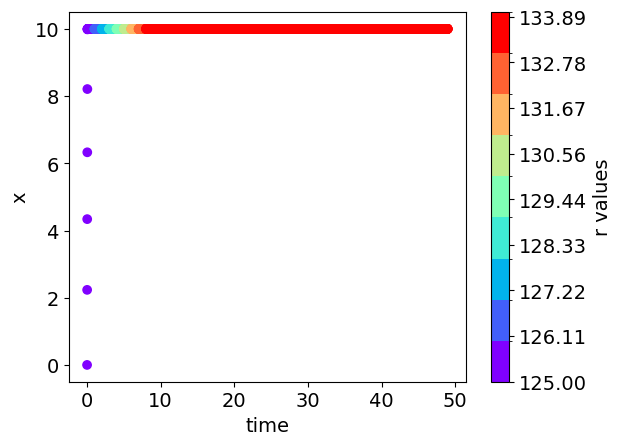

In [35]:
# Import the required modules
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint

import time

def dxdt(x,t,r):
    S = x[0]
    X = x[1]
    P = x[2]
    
    mu, Ks, Ki, Pmax, n = params1
    
    g = (1-P/Pmax)**(n)
    muB = mu*S/(Ks + S + S**2/Ki)*g
    pi = muB * alpha
    sigma = pi/Yps
    
    dSdt = -sigma*X
    dXdt = muB*X
    dPdt = pi*X
    
    
    return np.array([dSdt, dXdt, dPdt])


timesteps = np.arange(0,40,0.01)
mu = 0.5
Ks = 6.1e-3
Pmax = 94.2 
n = 4.12

X0 = 25.0 #g/L
S0 = 111.5 #g/L
P0 = 0 #g/L

initvals = np.array([X0, S0, P0])


# Set variables to collect later.
out_x = out_t = out_r= [];

for r in np.arange(125,135,1):

    # args must be a tuple, which is annnoying. A 1 element tuple needs a comma.
    # This doesn't effect tuples of more elements
    x = odeint(dxdt, initvals, timesteps, args=(r,))

    # Collect data for plotting
    out_x = np.append(out_x, x[:, 2]);
    out_t = np.append(out_t,timesteps);
    out_r = np.append(out_r,[r]*len(timesteps));
    
    # Update time steps and initial conditions for next loop
    timesteps = timesteps+1;
    initvals = x[-1] + 10**-12;
    
# Plot result. Have to do some fancy foot work to get a discrete colorbar
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("time")
plt.ylabel("x")
from matplotlib import colors
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(125,135,1), cmap.N)
plt.scatter(out_t, out_x, c= out_r,cmap=cmap, norm=norm);
cbar = plt.colorbar(ticks=np.linspace(125,135, 10))
cbar.set_label('r values');



In [ ]:
Use fsolve to find steady states and do simple bifurcation.
